# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
#Copied from Deep Learning Course Assignment 4
#Load libraries 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import display, Image
from six.moves import cPickle as pickle
import scipy.misc
import cv2
from PIL import Image
import scipy.ndimage

import urllib
import os.path
import scipy.io as scp
import tarfile
import sys
import h5py
from sklearn.preprocessing import normalize

%matplotlib inline


In [182]:
def reformat_mnist(dataset):
   dataset = dataset.reshape(
             (-1, image_size, image_size, num_channels)).astype(np.float32)
   return dataset

In [183]:
#Download MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

mnist_train_dataset = reformat_mnist(mnist.train.images)
mnist_test_dataset = reformat_mnist(mnist.test.images)
mnist_valid_dataset = reformat_mnist(mnist.validation.images)
mnist_train_labels = mnist.train.labels
mnist_test_labels = mnist.test.labels
mnist_valid_labels = mnist.validation.labels
print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
print('Validation set', mnist_valid_dataset.shape, mnist_valid_labels.shape)
print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training set (55000, 28, 28, 1) (55000, 10)
Validation set (5000, 28, 28, 1) (5000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [184]:
def tilt_image(image):
        random_degree = np.random.randint(-15, 15)
        rows, cols = image.shape[:2]
        center = (cols/2, rows/2)
        # i = scipy.ndimage.interpolation.rotate(i, random_degree,reshape = True )
        #image = Image.fromarray(i)
        #image = scipy.misc.toimage(i)
        matrix = cv2.getRotationMatrix2D(center, random_degree, 1)
        dst = cv2.warpAffine(i, matrix, ( cols, rows))
        return dst

In [185]:
#tilt images and then save it back as numpy array
train_tilted = [tilt_image(i) for i in mnist_train_dataset]
valid_tilted = [tilt_image(i) for i in mnist_valid_dataset]
test_tilted = [tilt_image(i) for i in mnist_test_dataset]

mnist_train_dataset = np.array(train_tilted)
mnist_valid_dataset = np.array(valid_tilted)
mnist_test_dataset = np.array(test_tilted)

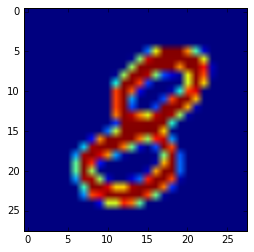

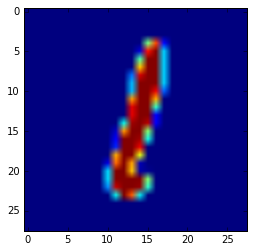

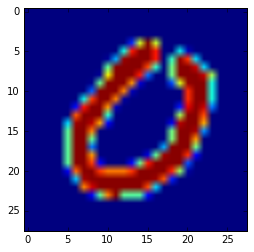

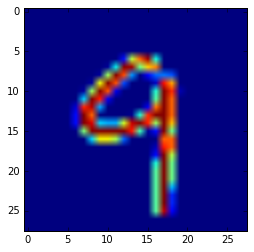

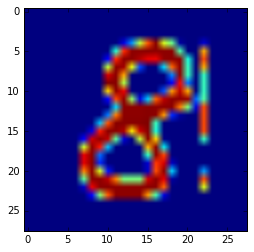

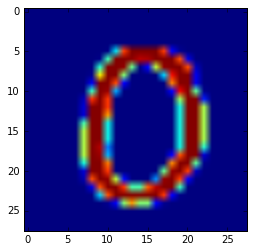

In [32]:
shape =mnist_train_dataset.shape
for i in range(5,11):
    image =mnist_train_dataset[i]
    image =image.reshape(shape[1], shape[2])
    plt.imshow(image)
    plt.show()

In [192]:
#change labels into simple labels instead of one-hot encoding
#e.g. [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] ==> 0
mnist_train_labels = [np.argmax(i)for i in mnist_train_labels]
mnist_train_labels= np.array(mnist_train_labels)
shape = mnist_train_labels.shape
mnist_train_labels = mnist_train_labels.reshape(shape[0], 1)

mnist_valid_labels = [np.argmax(i)for i in mnist_valid_labels]
mnist_valid_labels= np.array(mnist_valid_labels)
shape = mnist_valid_labels.shape
mnist_valid_labels = mnist_valid_labels.reshape(shape[0], 1)

mnist_test_labels = [np.argmax(i)for i in mnist_test_labels]
mnist_test_labels= np.array(mnist_test_labels)
shape = mnist_test_labels.shape
mnist_test_labels = mnist_test_labels.reshape(shape[0], 1)

print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
print('Validation set', mnist_valid_dataset.shape, mnist_valid_labels.shape)
print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)



Training set (55000, 28, 28) (55000, 1)
Validation set (5000, 28, 28) (5000, 1)
Test set (10000, 28, 28) (10000, 1)


In [44]:
#e.g . 32 ==> [10, 10, 10, 3, 2]
def mnist_fill_labels(label):
    size = len(label)
    if size >= 5:
        return label
    else :
        num_zeros = np.full((5-size), 10)
        return np.concatenate((num_zeros, label), axis = 0)

In [196]:
image_size = 28
image_width = image_size * 5
def concatenate(dataset, labels):
    np.random.seed(42)
    concatenated_images = [np.zeros((image_size, image_width))]
    concatenated_labels = [np.zeros((5))]
    i = 0
    while i < dataset.shape[0]:
        if dataset.shape[0] - i <=5:   # if the num of remaining images < 5
            image = dataset[i] 
            label = labels[i]
            for  j  in range( dataset.shape[0]-i -1): #for the remaining photos
                image = np.concatenate((image, dataset[i + j +1]), axis = 1)
                label = np.concatenate((label, labels[i+j +1]), axis = 0)
            label = mnist_fill_labels(label) #make it 5 classifiers 
            image = cv2.resize(image, ( image_width, image_size), interpolation = cv2.INTER_AREA)
            concatenated_images = np.vstack((concatenated_images, [image]))
            concatenated_labels= np.vstack((concatenated_labels, [label]))
            i = i + 5
        else:
            random_num = np.random.randint(3, 6)
            image = dataset[i]
            label = labels[i]
            for k in range(random_num-1):
                image = np.concatenate((image, dataset[i + k +1]), axis = 1)
                label = np.concatenate((label, labels[i + k +1]), axis = 0)
            label = mnist_fill_labels(label)
            image = cv2.resize(image, (image_width, image_size), interpolation = cv2.INTER_AREA)
            concatenated_images = np.vstack((concatenated_images, [image]))
            concatenated_labels= np.vstack((concatenated_labels, label))
            i = i + random_num
    concatenated_images = concatenated_images[1:]
    concatenated_labels =concatenated_labels[1:]

    return concatenated_images, concatenated_labels


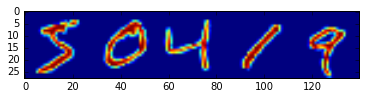

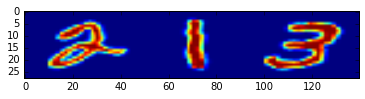

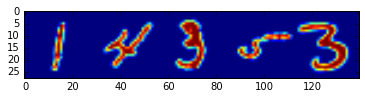

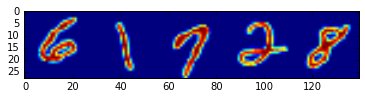

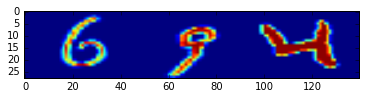

In [199]:
shape = mvd.shape
for i in range(0, 5):
    image =mvd[i]
    image =image.reshape(shape[1], shape[2])
    plt.imshow(image)
    plt.show()

In [ ]:
#concatenate images and labels into 3-5 digit sequences
mnist_train_dataset, mnist_train_labels  = concatenate(mnist_train_dataset, mnist_train_labels)
mnist_valid_dataset, mnist_valid_labels  = concatenate(mnist_valid_dataset, mnist_valid_labels)
mnist_test_dataset, mnist_test_labels  = concatenate(mnist_test_dataset, mnist_test_labels)
print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
print('Validation set', mnist_valid_dataset.shape, mnist_valid_labels.shape)
print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)

In [356]:
#reshape to 4-d
train_shape = mnist_train_dataset.shape
mnist_train_dataset = mnist_train_dataset.reshape(train_shape[0], train_shape[1], train_shape[2], 1)

valid_shape = mnist_valid_dataset.shape
mnist_valid_dataset = mnist_valid_dataset.reshape(valid_shape[0], valid_shape[1], valid_shape[2], 1)

test_shape = mnist_test_dataset.shape
mnist_test_dataset = mnist_test_dataset.reshape(test_shape[0], test_shape[1], test_shape[2], 1)
print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
print('Validation set', mnist_valid_dataset.shape, mnist_valid_labels.shape)
print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)

Training set (13788, 28, 140, 1) (13788, 5)
Validation set (1258, 28, 140, 1) (1258, 5)
Test set (2515, 28, 140, 1) (2515, 5)


In [357]:
#save into pickle file
pickle_file = 'MNIST_concatenated.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': mnist_train_dataset,
    'train_labels': mnist_train_labels,
    'valid_dataset': mnist_valid_dataset,
    'valid_labels': mnist_valid_labels,
    'test_dataset': mnist_test_dataset,
    'test_labels': mnist_test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [33]:
#load pickle file 
pickle_file = 'MNIST_concatenated.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  mnist_train_dataset = save['train_dataset']
  mnist_train_labels = save['train_labels']
  mnist_valid_dataset = save['valid_dataset']
  mnist_valid_labels = save['valid_labels']
  mnist_test_dataset = save['test_dataset']
  mnist_test_labels = save['test_labels']
  del save  
    
print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
print('Validation set', mnist_valid_dataset.shape, mnist_valid_labels.shape)
print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)

Training set (13788, 28, 140, 1) (13788, 5)
Validation set (1258, 28, 140, 1) (1258, 5)
Test set (2515, 28, 140, 1) (2515, 5)


In [ ]:
batch_size = 16 
patch_size = 3 #patch or filter is 5x10
patch_horiz = 7
depth = 32 #number of output channels or features learned e.g. lines,curves,etc.
num_hidden = 128
dropout = 0.93
image_size =28
image_horiz = 140
num_channels = 1
num_labels = 11

graph = tf.Graph()
with graph.as_default():
    
    #dataset = [16, 28, 28, 1]
    #labels = [16, 5]  5 labels 
    tf_train_dataset = tf.placeholder(tf.float32, shape = [batch_size, image_size, image_horiz, num_channels]) 
    tf_train_labels = tf.placeholder(tf.int32, shape = [batch_size, 5])
    tf_valid_dataset = tf.constant(mnist_valid_dataset)
    tf_test_dataset = tf.constant(mnist_test_dataset)
    
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape,stddev = 0.1)
        return tf.Variable(initial)
    def bias_variable(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)

    #[patch sizes, number of input channels, number of output channels]
    #strides for each dimension of input 
    # 2d because 2 dimension photo
    def conv2d(x,W):
        return tf.nn.conv2d(tf.cast(x, tf.float32), W, strides = [1,1,2,1], padding = 'SAME')
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize= [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    #Weights and Biases (Variables)
    # To First Convolutional Layer
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth ])
    b_conv1 = bias_variable([depth])
    # To Second Convolutional Layer
    W_conv2 = weight_variable([patch_size, patch_size, depth, depth*2])
    b_conv2 = bias_variable([depth*2])
    # To Fully Connected Layer 
    W_fc1 = weight_variable([ 4032, num_hidden])
    b_fc1 = bias_variable([num_hidden])
    #To output layer 
    W_output_1 = weight_variable([num_hidden, num_labels])
    b_output_1 = bias_variable([num_labels])
    W_output_2 = weight_variable([num_hidden, num_labels])
    b_output_2 = bias_variable([num_labels])
    W_output_3 = weight_variable([num_hidden, num_labels])
    b_output_3 = bias_variable([num_labels])
    W_output_4 = weight_variable([num_hidden, num_labels])
    b_output_4= bias_variable([num_labels])
    W_output_5 = weight_variable([num_hidden, num_labels])
    b_output_5  = bias_variable([num_labels])
    
    
    
    #relu: the activation function (multiplication part in each neuron )
    def model(data):
        conv1 = conv2d(data, W_conv1)
        hidden1 = tf.nn.relu(conv1 + b_conv1) #activation function
        h_pool1 = max_pool_2x2(hidden1)

        
        conv2 = conv2d(h_pool1, W_conv2)
        hidden2 = tf.nn.relu(conv2 + b_conv2)
        h_pool2 = max_pool_2x2(hidden2)

        shape = h_pool2.get_shape().as_list()
        reshape = tf.reshape(h_pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden3 = tf.nn.relu(tf.matmul(reshape, W_fc1) + b_fc1)

        output_layer_1 =  tf.matmul(hidden3, W_output_1) + b_output_1
        output_layer_2 =  tf.matmul(hidden3, W_output_2) + b_output_2
        output_layer_3 =  tf.matmul(hidden3, W_output_3) + b_output_3
        output_layer_4 =  tf.matmul(hidden3, W_output_4) + b_output_4
        output_layer_5 =  tf.matmul(hidden3, W_output_5) + b_output_5

        return [output_layer_1, output_layer_2, output_layer_3, output_layer_4, output_layer_5]
    
    [logits1, logits2, logits3,logits4,logits5] = model(tf_train_dataset) #the softmax result 
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,  0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:, 1])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:, 2])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,  3])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:, 4])) 
    
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),
                      tf.nn.softmax(model(tf_train_dataset)[1]),
                      tf.nn.softmax(model(tf_train_dataset)[2]),
                      tf.nn.softmax(model(tf_train_dataset)[3]),
                      tf.nn.softmax(model(tf_train_dataset)[4])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),
                      tf.nn.softmax(model(tf_valid_dataset)[1]),
                      tf.nn.softmax(model(tf_valid_dataset)[2]),
                      tf.nn.softmax(model(tf_valid_dataset)[3]),
                      tf.nn.softmax(model(tf_valid_dataset)[4])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                     tf.nn.softmax(model(tf_test_dataset)[1]),
                     tf.nn.softmax(model(tf_test_dataset)[2]),
                     tf.nn.softmax(model(tf_test_dataset)[3]),
                     tf.nn.softmax(model(tf_test_dataset)[4])])

In [361]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] 
            / predictions.shape[0])

In [362]:
num_steps = 10000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (mnist_train_labels.shape[0]-batch_size)
        batch_data = mnist_train_dataset[offset:(offset + batch_size), :, :]
        batch_labels = mnist_train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: dropout}
        
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
               valid_prediction.eval(), mnist_valid_labels))

    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(feed_dict = {keep_prob: 1.0}), mnist_test_labels))

Minibatch loss at step 0: 14.368933
Minibatch accuracy: 6.2%
Validation accuracy: 10.1%
Minibatch loss at step 500: 5.156927
Minibatch accuracy: 67.5%
Validation accuracy: 65.8%
Minibatch loss at step 1000: 3.416914
Minibatch accuracy: 66.2%
Validation accuracy: 77.6%
Minibatch loss at step 1500: 2.715867
Minibatch accuracy: 81.2%
Validation accuracy: 84.3%
Minibatch loss at step 2000: 2.540984
Minibatch accuracy: 80.0%
Validation accuracy: 86.6%
Minibatch loss at step 2500: 1.193279
Minibatch accuracy: 90.0%
Validation accuracy: 87.8%
Minibatch loss at step 3000: 1.254537
Minibatch accuracy: 91.2%
Validation accuracy: 89.6%
Minibatch loss at step 3500: 2.052184
Minibatch accuracy: 88.8%
Validation accuracy: 90.3%
Minibatch loss at step 4000: 0.523270
Minibatch accuracy: 97.5%
Validation accuracy: 90.3%
Minibatch loss at step 4500: 0.857496
Minibatch accuracy: 92.5%
Validation accuracy: 91.1%
Minibatch loss at step 5000: 1.636037
Minibatch accuracy: 87.5%
Validation accuracy: 91.4%
Min

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

The first approach I tried was identical to the model used in Assignment 4 of the Deep Learning Course. I wanted to make sure I understood the general process of using TensorFlow to create a graph of convolutional neural networks and executing it with the notMNIST dataset. This model has 2 convlutions with a stride 2 and the result was 89.8%. 
After adding two max pool layers of stride 2 and kernel size 2, the test accuracy was 88.6%. 
After further adding a dropout layer, the test accuracy was 91.3%.

Resubmit:
After correctly understanding the problem and creating the synthetic dataset, I tried various approaches by editing the structure of the convolutional neural network. Before tweaking the optimizer loss rate or the dropout rate to finalize the model, I needed to get to a point where the training accuracies reached around 70%. Some of the things I tried were changing the patches from 5x5 to 5x10 or changing the strides from (1,2, 2,1) to (1,1,2,1). I tried this from the notion that the width of the images(84) are larger than the height(28) so it made intuitive sense to have  unbalanced strides and patches. This also meant I had to continue to change the weight that connected to the fully connected layer. For example,  with strides of (1, 1,2, 1), the layers were the following: 

1. Layer1: Convolutional Layer 
    - Weights: [5 x 5 x 1 x 32]  where patch is (5x5), depth is 32
    - Result: [batch_size x 28 x 42 x 32]
2. Layer2: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
    - Result: [batch_size x 14 x 21 x 32]
3. Layer3: Convolutional Layer
    - Weights: [5 x 5 x 32 x 64]  
    - Result: [batch_size x 14 x 11 x 64]
4. Layer4: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
    - Result: [batch_size x 7 x 6 x 64]
    - Reshaped to [batch_size x 2688]
5. Layer5: Convolutional Layer (Fully Connected)
    - Weight: [2688 x 128]
    - Result: [batch_size x 128]
6. Layer 6: Dropout Layer
    - Result: [batch_size x 128]
7. Layer 7: Output Layers * 5 (1 for each digit)
    - Weights: [128x 11]
    - Result: [batch_size x 11]
    
The result of this structure, however, was very underwhelming again at training accuracy ranging in 20 - 30% range. 
This is when I had the thought that perhaps its the synthetic dataset that is the problem, not the architecture of the neural network. 
I came to this conclusion because the same or similar architectures as the one above performed relatively well with the SVHN dataset in the Part 2. Also, looking at the concatenated images, it was evident that the images were tilted too much and the letters were often unrecognizable even to the human eye. Learning from this mistake, I went on to the MNIST dataset instead, since the numbers seemed to be clearer and more similar to the SVHN dataset. Also, the concatenation process of notMNIST was much too long. 

As expected, after switching to MNIST, the results were much more impressive, with a mini batch accuracy peaking at 100% and the validation accuracy continually increasing until peaking at 92.9%. This shows that the model was not overfitting the data since the validation accuracy increased along with an increasing training accuracy. The final test score was 93.0%. 


### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
The final architecture is a convolutional neural network with two convolutional layers, each followed by a max pool layer, and finally, a fully connected layer. The number of fully connected layers is kept at 64 to make the computation less expensive.   


Resubmit:
	1.	Layer1: Convolutional Layer where strides = [1 x 1 x 2 x 1]
	•	Weights: [5 x 5 x 1 x 32] where patch is (5x5), depth is 32
	•	Result: [batch_size x 28 x 70 x 32]
	2.	Layer2: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
	•	Result: [batch_size x 14 x 35 x 32]
	3.	Layer3: Convolutional Layer
	•	Weights: [5 x 5 x 32 x 64]
	•	Result: [batch_size x 14 x 18 x 64]
	4.	Layer4: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
	•	Result: [batch_size x 7 x 9 x 64]
	•	Reshaped to [batch_size x 4032]
	5.	Layer5: Convolutional Layer (Fully Connected)
	•	Weight: [4032 x 128]
	•	Result: [batch_size x 128]
	6.	Layer 6: Dropout Layer
	•	Result: [batch_size x 128]
	7.	Layer 7: Output Layers * 5 (1 for each digit)
	•	Weights: [128x 11]
	•	Result: [batch_size x 11]

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
The way in which I loaded the dataset is equivalent to the relevant section in Assignment 4 of the Deep Learning Udacity course. I downloaded the pickle file onto my computer and it was subsequently separated into training sets, validation sets, and the test set. The labels were then reformatted into one-hot encodings with ten labels. 

Resubmit: I genereated the dataset in the following steps:
1. Tilt the images between -15 and 15 degrees using cv2 
2. Concatenate the tilted images into a image size of 28 x 84 (used 84 as the widthbecause the concatenation step took too much time with a width of 140)
3. Tilted the concatenated image again (example of image shown below)
4. For the labels, I simply concatenated the label into a 1x5 array, with 10 as the input if the digit is blank e.g. a label of 32 would have [10,10, 10, 3, 2]
5. Finally, I saved this data into a pickle file so it can easily be accessed later.

I trained the model by using the 28x84 image data as the data and the 1x5 array as labels.  

Update: after working with MNIST instead of notMNIST, the concatenation ended up with a dataset size of 28 x 140. Also, I omitted step 3. 


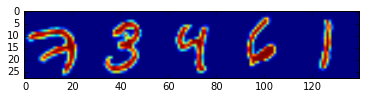

In [34]:
shape = mnist_train_dataset[0].shape
image = mnist_train_dataset[0].reshape(shape[0], shape[1])
plt.imshow(image)
plt.show()

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [363]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename
#247336696
train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967 )
valid_filename = maybe_download('extra.tar.gz', 1955489752 )

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz


In [364]:
num_classes = 0
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
valid_folders = maybe_extract(valid_filename)

train already present - Skipping extraction of train.tar.gz.
[]
test already present - Skipping extraction of test.tar.gz.
[]
extra already present - Skipping extraction of extra.tar.gz.
[]


In [ ]:
#saves the data stored into digitStruc.mat into a dictionary, and then a pickle file
def get_box_data(index, hdf5_data):
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])



train_struc= h5py.File('train/digitStruct.mat')

In [ ]:
#make a dictionary of names and bbox data for training
train_struc= h5py.File('train/digitStruct.mat')
metadata = {}
metadata['name'] = []
metadata['bbox'] = []
for i in range(train_struc['/digitStruct/bbox'].shape[0]):
    metadata['name'].append(get_name(i, train_struc))
    metadata['bbox'].append(get_box_data(i, train_struc))

In [ ]:
#make a dictionary of names and bbox data for testing
test_struc= h5py.File('test/digitStruct.mat')
metadata_test = {}
metadata_test['name'] = []
metadata_test['bbox'] = []
for i in range(test_struc['/digitStruct/bbox'].shape[0]):
    metadata_test['name'].append(get_name(i, test_struc))
    metadata_test['bbox'].append(get_box_data(i, test_struc))

In [ ]:
#make a dictionary of names and bbox data for testing

valid_struc= h5py.File('extra/digitStruct.mat')
metadata_valid = {}
metadata_valid['name'] = []
metadata_valid['bbox'] = []
for i in range(26032):
    metadata_valid['name'].append(get_name(i, valid_struc))
    metadata_valid['bbox'].append(get_box_data(i, valid_struc))

In [28]:
#save train data as pickle file
pickle_file = 'svhn_train_metadata.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print ('Unable to save data to', pickle_file, ':', e)
  raise

In [29]:

#save test data as pickle file
pickle_file = 'svhn_test_metadata.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(metadata_test, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print ('Unable to save data to', pickle_file, ':', e)
  raise

In [30]:

#save valid data as pickle file
pickle_file = 'svhn_valid_metadata.pickle'
try:
  pickleData = open(pickle_file, 'wb')
  pickle.dump(metadata_valid, pickleData, pickle.HIGHEST_PROTOCOL)
  pickleData.close()
except Exception as e:
  print ('Unable to save data to', pickle_file, ':', e)
  raise

In [370]:
#[3,2] ==> [0, 0, 0, 3, 2]
def fill_svhn_labels(label):
    size = len(label)
    if size == 5:
        return label
    else:
        num_zeros = np.full((5-size), 0)
        return np.concatenate((num_zeros, label), axis = 0)

In [ ]:
#instead use labels without one-hot encoding
#fill in empty digits with 10s (same as notMNIST labels)

s_train_labels = [i['label'] for i in train_bbox]
s_train_labels = [fill_svhn_labels(i) for i in s_train_labels]


s_test_labels = [i['label'] for i in test_bbox]
s_test_labels = [fill_svhn_labels(i) for i in s_test_labels]

s_valid_labels = [i['label'] for i in valid_bbox]
s_valid_labels = [fill_svhn_labels(i) for i in s_valid_labels]

In [310]:
#delete the label of an image which has 6 digits

s_train_labels = [i['label'] for i in train_bbox]
s_train_labels = np.delete(np.array(s_train_labels), 29929, 0)
s_train_labels = [fill_labels(i) for i in new]
s_train_labels = np.array(s_train_labels)
print (s_train_labels.shape)

(33401, 5)


In [371]:
# 1. crop out the image using the box data
# 2. make the image gray
# 3. resize to width = 100 and height =60
def load_folders(folder, t, b, l,  r):
    images = []
    files = os.listdir(folder)
    length = len(files)-2
    if folder == 'extra':
        length = 26032
    for i  in range(length): #os.listdir lists all the file names
        index = files.index(str(i+1) + '.png')
        img = cv2.imread(os.path.join(folder, files[index]))
        if img is not None:
            shape = img.shape[:2]
      
            pts2 = np.float32([[0,0],[shape[1],0],[0,shape[0]],[shape[1],shape[0]]])
            
            if b[i] > img.shape[0]:
                pts1 = np.float32([[l[i], t[i]], [r[i],t[i]], [l[i],shape[0]], [r[i],shape[0]]])
                M = cv2.getPerspectiveTransform(pts1,pts2)
                img = cv2.warpPerspective(img,M,(shape[1], shape[0]))
            elif r[i] > img.shape[1]:
                pts1 = np.float32([[l[i],t[i]], [shape[1],t[i]], [l[i],b[i]], [shape[1],b[i]]])
                M = cv2.getPerspectiveTransform(pts1,pts2)
                img = cv2.warpPerspective(img,M,(shape[1], shape[0]))
            else: 
                pts1 = np.float32([[l[i],t[i]], [r[i],t[i]], [l[i],b[i]], [r[i],b[i]]])
                M = cv2.getPerspectiveTransform(pts1,pts2)
                img = cv2.warpPerspective(img,M,(shape[1], shape[0]))
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_image = cv2.resize(gray_image, (100, 60), interpolation = cv2.INTER_AREA)
            images.append(resize_image)
    return images


In [ ]:
#use bbox information to crop and resize images

#a list of all bbox info
train_left = [i['left'] for i in metadata['bbox']]
train_height = [i['height'] for i in metadata['bbox']]
train_width = [i['width'] for i in metadata['bbox']]
train_top = [i['top'] for i in metadata['bbox']]

#find coordinates for top, bottom, left, right corners in each image
train_t = [min(i) for i in train_top] 
train_b = [max(i) + max(j) for i,j in zip(train_top, train_height)]
train_l = [min(i) for i in train_left]
train_r = [max(i) + max(j) for i, j  in zip(train_left, train_width)]
s_train_dataset = load_folders('train', train_t, train_b, train_l, train_r)
s_train_dataset =np.array(s_train_dataset) 



In [ ]:
#use bbox information to crop and resize images

#a list of all bbox info
test_left = [i['left'] for i in metadata_test['bbox']]
test_height = [i['height'] for i in metadata_test['bbox']]
test_width = [i['width'] for i in metadata_test['bbox']]
test_top = [i['top'] for i in metadata_test['bbox']]

#find coordinates for top, bottom, left, right corners in each image
test_t = [min(i) for i in test_top] 
test_b = [max(i) + max(j) for i,j in zip(test_top, test_height)]
test_l = [min(i) for i in test_left]
test_r = [max(i) + max(j) for i, j  in zip(test_left, test_width)]
s_test_dataset = load_folders('test', test_t, test_b, test_l, test_r)
s_test_dataset =np.array(s_test_dataset) 

In [ ]:
#use bbox information to crop and resize images

#a list of all bbox info
valid_left = [i['left'] for i in metadata_valid['bbox']]
valid_height = [i['height'] for i in metadata_valid['bbox']]
valid_width = [i['width'] for i in metadata_valid['bbox']]
valid_top = [i['top'] for i in metadata_valid['bbox']]

#find coordinates for top, bottom, left, right corners in each image
valid_t = [min(i) for i in valid_top] 
valid_b = [max(i) + max(j) for i,j in zip(valid_top, valid_height)]
valid_l = [min(i) for i in valid_left]
valid_r = [max(i) + max(j) for i, j  in zip(valid_left, valid_width)]
s_valid_dataset = load_folders('extra', valid_t, valid_b, valid_l, valid_r)
s_valid_dataset =np.array(s_valid_dataset) 

In [376]:
#delete the image with 6 digits
s_train_dataset = np.delete(s_train_dataset, 29929, 0)
print('Training set', s_train_dataset.shape, s_train_labels.shape)
print('Validation set', s_valid_dataset.shape, s_valid_labels.shape)
print('Test set', s_test_dataset.shape, s_test_labels.shape)


Training set (33401, 60, 100) (33401, 5)
Validation set (26032, 60, 100) (26032, 5)
Test set (13068, 60, 100) (13068, 5)


In [ ]:
#make the labels numpy arrays
s_train_labels = np.array(s_train_labels)
s_test_labels = np.array(s_test_labels)
s_valid_labels = np.array(s_valid_labels)

In [377]:
#resize dataset to 4-d

train_shape = s_train_dataset.shape
s_train_dataset = s_train_dataset.reshape(train_shape[0], train_shape[1], train_shape[2], 1)

valid_shape = s_valid_dataset.shape
s_valid_dataset = s_valid_dataset.reshape(valid_shape[0], valid_shape[1], valid_shape[2], 1)

test_shape = s_test_dataset.shape
s_test_dataset = s_test_dataset.reshape(test_shape[0], test_shape[1], test_shape[2], 1)

print('Training set', s_train_dataset.shape, s_train_labels.shape)
print('Validation set', s_valid_dataset.shape, s_valid_labels.shape)
print('Test set', s_test_dataset.shape, s_test_labels.shape)

Training set (33401, 60, 100, 1) (33401, 5)
Validation set (26032, 60, 100, 1) (26032, 5)
Test set (13068, 60, 100, 1) (13068, 5)


In [378]:
#save into pickle file

pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': s_train_dataset,
    'train_labels': s_train_labels,
    'valid_dataset': s_valid_dataset,
    'valid_labels': s_valid_labels,
    'test_dataset': s_test_dataset,
    'test_labels': s_test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [ ]:
#load metadata

#load train pickle file
pickle_file = 'svhn_train_metadata.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_names = save['name']
  train_names.remove(train_names[29929]) #discard the 6 digit image
  train_bbox = save['bbox']
  train_bbox.remove(train_bbox[29929]) #discard the 6 digit image

  del save  

#load test pickle file
pickle_file = 'svhn_test_metadata.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  test_names = save['name']
  test_bbox = save['bbox']
  del save  
    
#load valid pickle file
pickle_file = 'svhn_valid_metadata.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  valid_names = save['name']
  valid_bbox = save['bbox']
  del save  

In [2]:
#load dataset

pickle_file = 'SVHN.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  s_train_dataset = save['train_dataset']
  s_train_labels = save['train_labels']
  s_valid_dataset = save['valid_dataset']
  s_valid_labels = save['valid_labels']
  s_test_dataset = save['test_dataset']
  s_test_labels = save['test_labels']
  del save  
  print('Training set', s_train_dataset.shape, s_train_labels.shape)
  print('Validation set', s_valid_dataset.shape, s_valid_labels.shape)
  print('Test set', s_test_dataset.shape, s_test_labels.shape)


Training set (33401, 60, 100, 1) (33401, 5)
Validation set (26032, 60, 100, 1) (26032, 5)
Test set (13068, 60, 100, 1) (13068, 5)


In [ ]:
depth = 16
patch_size = 5
num_hidden = 128
dropout = 0.93
batch_size = 16
image_size = 60
image_width = 100
num_channels  = 1
num_labels = 11


graph_svhn= tf.Graph()
with graph_svhn.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = [batch_size, image_size, image_width, num_channels]) 
    tf_train_labels = tf.placeholder(tf.int32, shape = [batch_size, 5])
    tf_test_dataset = tf.constant(s_test_dataset, tf.float32)
    tf_valid_dataset = tf.constant(s_valid_dataset, tf.float32)
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
    tf_own_dataset = tf.placeholder(tf.float32, shape = [5, image_size, image_width, num_channels]) 
    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape,stddev = 0.1)
        return tf.Variable(initial)
    def bias_variable(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)

    def conv2d(x,W):
        return tf.nn.conv2d(x, W, strides = [1,1,2,1], padding = 'SAME')
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize= [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    #Weights and Biases (Variables)
    # To First Convolutional Layer
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth ])
    b_conv1 = bias_variable([depth])
    # To Second Convolutional Layer
    W_conv2 = weight_variable([patch_size, patch_size, depth, depth*2])
    b_conv2 = bias_variable([depth*2])
    #to Third convolutional layer
    W_conv3 = weight_variable([patch_size, patch_size, depth*2, depth*4])
    b_conv3 = bias_variable([depth*4])
    # To Fully Connected Layer 
    W_fc1 = weight_variable([ 1024, num_hidden])
    b_fc1 = bias_variable([num_hidden])
    #To output layer 
    W_output_1 = weight_variable([num_hidden, num_labels])
    b_output_1 = bias_variable([num_labels])
    W_output_2 = weight_variable([num_hidden, num_labels])
    b_output_2 = bias_variable([num_labels])
    W_output_3 = weight_variable([num_hidden, num_labels])
    b_output_3 = bias_variable([num_labels])
    W_output_4 = weight_variable([num_hidden, num_labels])
    b_output_4= bias_variable([num_labels])
    W_output_5 = weight_variable([num_hidden, num_labels])
    b_output_5  = bias_variable([num_labels])
    
    def model(data):
        conv1 = conv2d(data, W_conv1)
        hidden1 = tf.nn.relu(conv1 + b_conv1) #activation function
        h_pool1 = max_pool_2x2(hidden1)
        
        conv2 = conv2d(h_pool1, W_conv2)
        hidden2 = tf.nn.relu(conv2 + b_conv2)
        h_pool2 = max_pool_2x2(hidden2)
        
        conv3 = conv2d(h_pool2, W_conv3)
        hidden3 = tf.nn.relu(conv3 + b_conv3)
        h_pool3 = max_pool_2x2(hidden3)
        
        shape = h_pool3.get_shape().as_list()
        reshape = tf.reshape(h_pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden3 = tf.nn.relu(tf.matmul(reshape, W_fc1) + b_fc1)
        
        #dropout layer
        hidden3_drop = tf.nn.dropout(hidden3, dropout)

        output_layer_1 =  tf.matmul(hidden3_drop, W_output_1) + b_output_1
        output_layer_2 =  tf.matmul(hidden3_drop, W_output_2) + b_output_2
        output_layer_3 =  tf.matmul(hidden3_drop, W_output_3) + b_output_3
        output_layer_4 =  tf.matmul(hidden3_drop, W_output_4) + b_output_4
        output_layer_5 =  tf.matmul(hidden3_drop, W_output_5) + b_output_5
        prediction = tf.argmax(tf.pack([
                tf.argmax(tf.nn.softmax(output_layer_1), 1),
                tf.argmax(tf.nn.softmax(output_layer_2), 1),
                 tf.argmax(tf.nn.softmax(output_layer_3), 1),
                 tf.argmax(tf.nn.softmax(output_layer_4), 1),
                tf.argmax(tf.nn.softmax(output_layer_5), 1)]), 1)
        return [output_layer_1, output_layer_2, output_layer_3, output_layer_4, output_layer_5]
    
    [logit1, logit2, logit3,logit4,logit5] = model(tf_train_dataset) #the softmax result 
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit1, tf_train_labels[:,  0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit2, tf_train_labels[:, 1])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit3, tf_train_labels[:, 2])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit4, tf_train_labels[:,  3])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit5, tf_train_labels[:, 4])) 
    
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),
                      tf.nn.softmax(model(tf_train_dataset)[1]),
                      tf.nn.softmax(model(tf_train_dataset)[2]),
                      tf.nn.softmax(model(tf_train_dataset)[3]),
                      tf.nn.softmax(model(tf_train_dataset)[4])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),
                      tf.nn.softmax(model(tf_valid_dataset)[1]),
                      tf.nn.softmax(model(tf_valid_dataset)[2]),
                      tf.nn.softmax(model(tf_valid_dataset)[3]),
                      tf.nn.softmax(model(tf_valid_dataset)[4])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                     tf.nn.softmax(model(tf_test_dataset)[1]),
                     tf.nn.softmax(model(tf_test_dataset)[2]),
                     tf.nn.softmax(model(tf_test_dataset)[3]),
                     tf.nn.softmax(model(tf_test_dataset)[4])])
    
    own_prediction = tf.pack([tf.nn.softmax(model(tf_own_dataset)[0]),
                     tf.nn.softmax(model(tf_own_dataset)[1]),
                     tf.nn.softmax(model(tf_own_dataset)[2]),
                     tf.nn.softmax(model(tf_own_dataset)[3]),
                     tf.nn.softmax(model(tf_own_dataset)[4])])
    
    saver = tf.train.Saver()

In [34]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] 
            / predictions.shape[0])

In [47]:
num_steps = 10000
with tf.Session(graph=graph_svhn) as session:
    tf.initialize_all_variables().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (s_train_labels.shape[0]-batch_size)
        batch_data = s_train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = s_train_labels[offset: (offset + batch_size), :]
        if batch_data.shape[0] != batch_size:
            break
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: dropout}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 200 == 0):
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
          print('Validation accuracy: %.1f%%' % accuracy(
          valid_prediction.eval(), s_valid_labels))
    saved_path =saver.save(session,  'svhn_graph.ckpt')
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), s_test_labels))


Minibatch loss at step 0: 2105.313477
Minibatch accuracy: 1.2%
Validation accuracy: 11.5%
Minibatch loss at step 200: 5.406993
Minibatch accuracy: 63.8%
Validation accuracy: 50.1%
Minibatch loss at step 400: 6.225827
Minibatch accuracy: 61.2%
Validation accuracy: 51.5%
Minibatch loss at step 600: 5.927179
Minibatch accuracy: 62.5%
Validation accuracy: 50.7%
Minibatch loss at step 800: 6.182320
Minibatch accuracy: 61.2%
Validation accuracy: 50.8%
Minibatch loss at step 1000: 6.334492
Minibatch accuracy: 56.2%
Validation accuracy: 50.8%
Minibatch loss at step 1200: 5.954424
Minibatch accuracy: 62.5%
Validation accuracy: 51.7%
Minibatch loss at step 1400: 6.111396
Minibatch accuracy: 55.0%
Validation accuracy: 52.2%
Minibatch loss at step 1600: 6.301617
Minibatch accuracy: 60.0%
Validation accuracy: 52.0%
Minibatch loss at step 1800: 6.014482
Minibatch accuracy: 56.2%
Validation accuracy: 52.3%
Minibatch loss at step 2000: 5.437634
Minibatch accuracy: 63.8%
Validation accuracy: 53.4%
Mini

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**
The way in which I set up the training and testing data for the model is the following:
1. Download the tar file, and extract the images. 
2. Use the digitStruct.mat file to save information about the bounding boxes and the labels for each image. Save them in a pickle file for later use.
3. For the labels, fill in the empty labels with 0s e.g. a label of 32 turns into 00032
4. Since all of the images are different sizes, turn them into the same size with a width of 100 and height of 60. Do this by using the bounding box information to get the minimum upper left corner value maximum bottom right corner value to create a large box that fits all the digits. Crop the digits out, make the images gray and resize them to 100 x 60. 
5. Delete one outlier which had 6 digits. 
6. Save into pickle file for later use

With this model, it reached a peak validation accuracy of 73.6% and a peak mini batch accuracy of 83.8%. The model seemed to improve with more iterations, so perhaps the results would improve by increasing epoch. Although the increase in both scores were not linear, overall, both scores improved together and so we can say the model did not overfit. The final test score was 83.1%. 


### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
When i simply implemented the model I used for the Part 1, both the validation and batch accuracies peaked at around 60%.

One large change I made was in the structure of the model  as seen below. 
Input Image Size: [batch_size x 60 x 100 x 1]
	1.	Layer1: Convolutional Layer where strides = [1 x 1 x 2 x 1]
	•	Weights: [5 x 5 x 1 x 16] where patch is (5x5), depth is 16
	•	Result: [batch_size x 60 x 50 x 16]
	2.	Layer2: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
	•	Result: [batch_size x 30 x 25 x 16]
	3.	Layer3: Convolutional Layer
	•	Weights: [5 x 5 x 16 x 32]
	•	Result: [batch_size x 30 x 13 x 32]
	4.	Layer4: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
	•	Result: [batch_size x 15 x 7 x 32]
	5.	Layer 5: Convolutional Layer
	•	Weights: [ 5 x 5 x 32 x 64]
	•	Result: [batch_size x 8 x 2 x 64]
	6.	Layer 6: Max-Pool Layer where strides = [1 x 2 x 2 x 1]
	•	Result: [batch_size x 8 x 2 x 64]
	•	Resized to [batch_size x 124]
	7.	Layer7: Convolutional Layer (Fully Connected)
	•	Weight: [1024 x 128]
	•	Result: [batch_size x 128]
	8.	Layer 8: Dropout Layer
	•	Result: [batch_size x 128]
	9.	Layer 9: Output Layers * 5 (1 for each digit)
	•	Weights: [128x 11]
	•	Result: [batch_size x 11]

As you can see, one additional convolutional layer and a max-pool layer was added and the results improved significantly.One change I made that worsened performance was changing the patch size to 5 x 10 instead of 5 x 5.
Also, it turns out that the size of the image is very important. The performance was very poor when I tried training with 32 x 32 images. But after changing the size to 100 x 60, which is close to the average original size of all images, the accuracy was significantly higher. This means that maintaining as much as possible the original resolution is important, as significantly resizing the image blurs it out and makes it hard to classify.  

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
My initial results were 15.1 % after using the same architecture as Part 1 and changing the depth to 50 and number of fully connected nodes to 200. After making the images grayscale and changing the strides to 1 instead of 2, the results were again underwhelming with a test score of 16.8%. 

Resubmit:
The above answer was from implementing a model which only predicts single digits, hence the poor perormance. 
My initial results(with multidigit classification), ranged from 50 to 60% on the mini batch and validation accuracies with a peak of around 62% for the mini batch and 55 for the validation accuracies. After increasing the number of layers from 7 to 9, the results were significantly better. The a peak validation accuracy was 73.6% and the peak mini batch accuracy was 83.8%. My final test score is 83.1%. Due to limited computing resources (as each training took up to 12 hours), I was not able to do enough hyper parameter tuning, which may have increased performance by a few percentage points. Although this model scores lower than that of Goodfellow’s, the performance here seems to be pretty good considering the number of images I used(33401, 13068, 26032 for training, validation and testing) and the limited computing resources I had. This is not a performance that is ready to use for Google apps or self-driving cars, but it is certainly a start to building a better model in perhaps a different environment. 

Resubmit 2: 

My initial results (which used the same exact model as Part 1), ranged from 50 to 60% on the mini batch and validation accuracies, with a peak of around 62% for the mini batch and 55% for the validation accuracies. After increasing the number of layers from 7 to 9, the results were significantly better. The a peak validation accuracy was 73.6% and the peak mini batch accuracy was 83.8%. My final test score is 83.1%. Due to limited computing resources (as each training took up to 12 hours), I was not able to do enough hyper parameter tuning, which may have increased performance by a few percentage points. For example, I could've ran training again after attempting different loss functions, different learning rates, increasing epochs or adding more layers. Another method I did not use in this part was randomizing the dataset, so that similar images are spread out across the dataset. 

Overall, the performance here seems to be pretty good considering the number of images I used(33401, 13068, 26032 for training, validation and testing) and the limited computing resources I had. This is certainly not a performance that is ready to use for Google apps or self-driving cars, but it is certainly a start to building a better model in perhaps a different environment. 

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [2]:
def load_own_images(folder):
    images = []
    files = os.listdir(folder)
    for i  in range(0,5): #since some unnecessary files are included in the folder
        img = cv2.imread(os.path.join(folder, files[i]))
        if img is not None:
            shape = img.shape
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(gray_image)
    return images

In [ ]:
# the images were resized to 60, 100 directly on the images beforehand 
own_data = load_own_images('taken_photos')
#print (len(own_data))

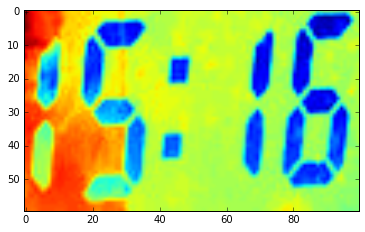

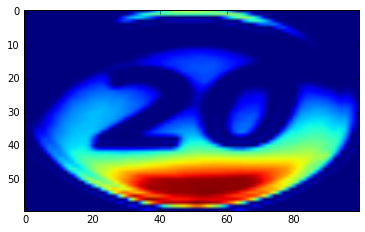

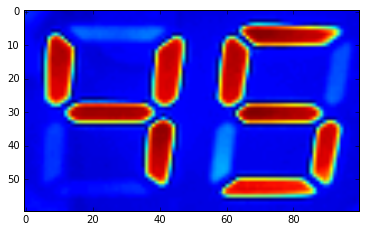

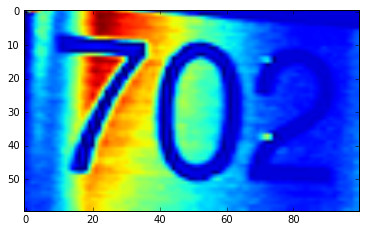

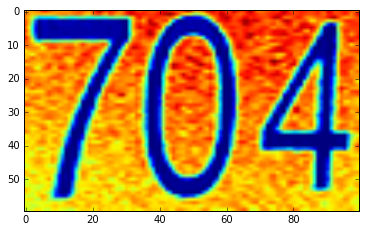

In [15]:
shape =np.array(own_data).shape

for i in range(len(own_data)):
    image = np.array(own_data[i])
    image =image.reshape(shape[1], shape[2])
    plt.imshow(image)
    plt.show()

In [16]:
own_data = np.array(own_data)
shape = own_data.shape
own_data = own_data.reshape(shape[0], shape[1], shape[2], 1)
print (own_data.shape)

(5, 60, 100, 1)


In [ ]:
#manually make own labels 
labels = [[0, 1, 5, 1, 6], [0, 0, 0, 2, 10], [0, 0, 0, 4, 5] , [0, 0, 7, 10, 2], [0, 0, 7, 10, 4]]
own_labels = np.array(labels)

In [24]:
with tf.Session(graph=graph_svhn) as session:
  
  saver.restore(session, "svhn_graph.ckpt")
  prediction = session.run(own_prediction, feed_dict={tf_own_dataset : own_data})
  print (np.argmax(prediction, axis  =2))
print('Test accuracy: %.1f%%' % accuracy(prediction, own_labels))

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  1]
 [ 5  0  1  3 10]
 [ 6  1  6 10  4]]
Test accuracy: 56.0%


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**
As evident in the images above, two of the images show time, with one image containg a colon that could confuse the classification process. Also, one other image is contained inside a circle. The fourth image is number on a silver plate, which may cause a glare. The fifth image is relatively normal with clear numbers and not much background noise. 

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

As predicted, the results were a bit underwhelming and the model did not perform that well. Even after training on over 30,000 images, it proved too difficult to predict numbers when the images had too much noise. Whether it was a glare from the background or digital numbers with colons in between, the model did not have enough variation while training to crop out the numbers and understand it. It could be the case that to improve this problem, there needs to be an extra process of blurring out the image even further to make the resolution lower. This way, the space between each digit in a digital clock, for example, can be blurred out and appear like the other numbers. 

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [29]:
#load metadata

#load train pickle file
pickle_file = 'svhn_train_metadata.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_names = save['name']
  #train_names.remove(train_names[29929]) #discard the 6 digit image
  train_bbox = save['bbox']
  #train_bbox.remove(train_bbox[29929]) #discard the 6 digit image

  del save  

#load test pickle file
pickle_file = 'svhn_test_metadata.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  test_names = save['name']
  test_bbox = save['bbox']
  del save  
    
#load valid pickle file
pickle_file = 'svhn_valid_metadata.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  valid_names = save['name']
  valid_bbox = save['bbox']
  del save  

print('Training set', len(train_names), len(train_bbox))
print('Validation set', len(test_names), len(test_bbox))
print('Test set', len(valid_names), len(valid_bbox))

Training set 33402 33402
Validation set 13068 13068
Test set 26032 26032


In [ ]:
s_train_left = [i['left'] for i in train_bbox]
s_train_up = [i['top'] for i in train_bbox]
s_train_width = [i['width'] for i in train_bbox]
s_train_height = [i['height'] for i in train_bbox]

s_test_left = [i['left'] for i in test_bbox]
s_test_up = [i['top'] for i in test_bbox]
s_test_width = [i['width'] for i in test_bbox]
s_test_height = [i['height'] for i in test_bbox]

s_valid_left = [i['left'] for i in valid_bbox]
s_valid_up = [i['top'] for i in valid_bbox]
s_valid_width = [i['width'] for i in valid_bbox]
s_valid_height = [i['height'] for i in valid_bbox]

#print (s_train_left[0])

In [71]:
#find average width and height of images to get an idea of what width and height we should use
def find_average(folder):
    files = os.listdir(folder)
    width = 0
    height = 0
    files = files[:-2]
    if folder == 'extra':
        files = files[:26032]
    for f in files:
        img = cv2.imread(os.path.join(folder, f))
        shape = img.shape
        width +=shape[1]
        height +=shape[0]
    avg_width = width/len(files)
    avg_height = height/len(files)
    return  avg_width, avg_height

In [72]:
print (find_average('train'))
print (find_average('test'))
print (find_average('extra'))

(128, 57)
(172, 71)
(100, 60)


In [284]:
image_width = 100
image_height = 60
def load_uncropped_folders(folder, l, t, w, h):
    images = []
    left = []
    top = []
    height = []
    width =[]
    files = os.listdir(folder)
    length = len(files)-2
    if folder == 'extra':
        length = 26032

    for i  in range(length):#os.listdir lists all the file names
        if i % 1000 ==0: print (i)
        index = files.index(str(i+1) + '.png')
        img = cv2.imread(os.path.join(folder, files[index]))
        if img is not None:
            shape =img.shape
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            resize_image = cv2.resize(gray_image, (image_width, image_height), interpolation = cv2.INTER_AREA)
            height_ratio = image_height/float(shape[0])
            width_ratio = image_width/float(shape[1])

            #change the bbox information to fit resizing 
            box_left = []
            box_top = []
            box_height = []
            box_width = []
            for j in range(len(w[i])):
                box_left.append( int(l[i][j] * width_ratio))
                box_top.append( int(t[i][j] * height_ratio))
                box_height.append( int(h[i][j] * height_ratio))
                box_width.append( int(w[i][j] * width_ratio))
            images.append(resize_image)
            width.append(box_width)
            left.append(box_left)
            top.append(box_top)
            height.append(box_height) 
    return images, left, top, width, height

In [ ]:
svhn_train_dataset, svhn_train_left, svhn_train_up, \
svhn_train_width, svhn_train_height \
=load_uncropped_folders('train', s_train_left, s_train_up, s_train_width, s_train_height)

svhn_valid_dataset, svhn_valid_left, svhn_valid_up, \
svhn_valid_width, svhn_valid_height \
=load_uncropped_folders('extra', s_valid_left, s_valid_up, s_valid_width, s_valid_height)

svhn_test_dataset, svhn_test_left, svhn_test_up, \
svhn_test_width, svhn_test_height \
=load_uncropped_folders('test', s_test_left, s_test_up, s_test_width, s_test_height)

In [290]:
#remove the data point which has 6 digits

svhn_train_dataset = np.array(svhn_train_dataset[:29929]+svhn_train_dataset[29930:])
svhn_train_left = np.array(svhn_train_left[:29929]+svhn_train_left[29930:])
svhn_train_up = np.array(svhn_train_up[:29929]+svhn_train_up[29930:])
svhn_train_width = np.array(svhn_train_width[:29929]+svhn_train_width[29930:])
svhn_train_height = np.array(svhn_train_height[:29929]+svhn_train_height[29930:])

[ 0.  0.  0.  3.  1.]


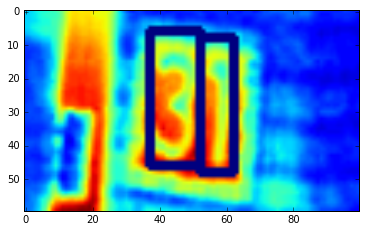

In [4]:
#check if the box data is still okay after resizing the images and box data
image = svhn_train_dataset[4]
shape = svhn_train_dataset[4].shape
image = image.reshape(shape[0], shape[1])
cv2.rectangle(image, (svhn_train_left[4][0], svhn_train_top[4][0]), (svhn_train_left[4][0]+svhn_train_width[4][0], svhn_train_top[4][0] + svhn_train_height[4][0]), (0, 255,0), 2)
cv2.rectangle(image, (svhn_train_left[4][1], svhn_train_top[4][1]), (svhn_train_left[4][1]+svhn_train_width[4][1], svhn_train_top[4][1] + svhn_train_height[4][1]), (0, 255,0), 2)
#cv2.rectangle(image, (svhn_train_left[4][2], svhn_train_up[4][2]), (svhn_train_left[4][2]+svhn_train_width[4][2], svhn_train_up[4][2] + svhn_train_height[4][2]), (0,255,0), 2)

plt.imshow(image)
plt.show()


In [300]:
#resize to 4-d
train_shape = svhn_train_dataset.shape
svhn_train_dataset = svhn_train_dataset.reshape(train_shape[0], train_shape[1], train_shape[2], 1)

svhn_valid_dataset = np.array(svhn_valid_dataset)
valid_shape = svhn_valid_dataset.shape
svhn_valid_dataset = svhn_valid_dataset.reshape(valid_shape[0], valid_shape[1], valid_shape[2], 1)

svhn_test_dataset = np.array(svhn_test_dataset)
test_shape = svhn_test_dataset.shape
svhn_test_dataset = svhn_test_dataset.reshape(test_shape[0], test_shape[1], test_shape[2], 1)

print('Training set', svhn_train_dataset.shape, s_train_labels.shape)
print('Validation set', svhn_valid_dataset.shape, s_valid_labels.shape)
print('Test set', svhn_test_dataset.shape, s_test_labels.shape)

Training set (33401, 60, 100, 1) (33401, 5)
Validation set (26032, 60, 100, 1) (26032, 5)
Test set (13068, 60, 100, 1) (13068, 5)


In [ ]:
#reshape to 2-d
shape = np.array(svhn_train_left).shape
svhn_train_left = np.array(svhn_train_left).reshape(shape[0], 1)
svhn_train_up = np.array(svhn_train_up).reshape(shape[0], 1)
svhn_train_width = np.array(svhn_train_width).reshape(shape[0], 1)
svhn_train_height = np.array(svhn_train_height).reshape(shape[0], 1)


shape = np.array(svhn_valid_left).shape
svhn_valid_left = np.array(svhn_valid_left).reshape(shape[0], 1)
svhn_valid_up = np.array(svhn_valid_up).reshape(shape[0], 1)
svhn_valid_width = np.array(svhn_valid_width).reshape(shape[0], 1)
svhn_valid_height = np.array(svhn_valid_height).reshape(shape[0], 1)


shape = np.array(svhn_test_left).shape
svhn_test_left = np.array(svhn_test_left).reshape(shape[0], 1)
svhn_test_up = np.array(svhn_test_up).reshape(shape[0], 1)
svhn_test_width = np.array(svhn_test_width).reshape(shape[0], 1)
svhn_test_height = np.array(svhn_test_height).reshape(shape[0], 1)

In [32]:

#fill in empty box data with 101 (since the images are 60  x 100, there will be no 101)
def fill_box_labels(left, top, width, height ):
    size = np.array(left).shape
    #print (size)
    if size == 5:
        return np.concatenate((left, top, width, height), axis = 0)
    else:
        num_zeros = np.full((5-size[0]), 101)
        #print (num_zeros)
        l = np.concatenate((num_zeros, np.array(left)) )#, axis = 0)
        t = np.concatenate((num_zeros, np.array(top)))#, axis = 0)
        w = np.concatenate((num_zeros, np.array(width)))#, axis = 0)
        h = np.concatenate((num_zeros, np.array(height)))#, axis = 0)
        return np.vstack((l, t, w, h))
        #return np.concatenate((l, t, w, h), axis = 1)

In [34]:
train_box_data = np.array([fill_box_labels(svhn_train_left[i], svhn_train_top[i], svhn_train_width[i],svhn_train_height[i] ) for i in range(len(svhn_train_left))])
test_box_data = np.array([fill_box_labels(svhn_test_left[i], svhn_test_top[i], svhn_test_width[i], svhn_test_height[i] ) for i in range(len(svhn_test_left))])
valid_box_data = np.array([fill_box_labels(svhn_valid_left[i], svhn_valid_top[i], svhn_valid_width[i],svhn_valid_height[i] ) for i in range(len(svhn_valid_left))])
print('Training set', svhn_train_dataset.shape, train_box_data.shape)
print('Validation set', svhn_valid_dataset.shape, valid_box_data.shape)
print('Test set', svhn_test_dataset.shape, test_box_data.shape)

Training set (33401, 60, 100, 1) (33401, 4, 5)
Validation set (26032, 60, 100, 1) (26032, 4, 5)
Test set (13068, 60, 100, 1) (13068, 4, 5)


In [36]:
def flip(dataset):
    shape = dataset.shape
    flipped_dataset = np.zeros((shape[0], shape[2], shape[1]))
    for i in range(shape[0]):
        flipped_dataset[i] = np.rot90(np.rot90(np.rot90(dataset[i])))
    return flipped_dataset

In [ ]:
train_box_data = flip(train_box_data)
valid_box_data = flip(valid_box_data)
test_box_data = flip (test_box_data)

In [40]:
# instead of [left, up, width, height], make it [left, up, right, bottom] 
#or [x1, y1, x2, y2] where x1, y1 is the upper left corner 
# and x2, y2 is the bottom right corner
 
def change_box_data(box_data, left):
    new_box_data = np.full((5,4), 101)
    shape = len(left) 
    print (shape)
    for i in range(4, 4-shape, -1): 
        new_box_data[i][0] = box_data[i][3]
        new_box_data[i][1] = box_data[i][2]
        new_box_data[i][2] = box_data[i][3] + box_data[i][1]
        new_box_data[i][3] = box_data[i][2]+ box_data[i][0]
    return new_box_data


In [ ]:
train_box_data = [change_box_data(train_box_data[i], svhn_train_left[i]) for i in range(train_box_data.shape[0])]
valid_box_data = [change_box_data(valid_box_data[i], svhn_valid_left[i]) for i in range(valid_box_data.shape[0])]
test_box_data = [change_box_data(test_box_data[i], svhn_test_left[i]) for i in range(test_box_data.shape[0])]

train_box_data = np.array(train_box_data)
valid_box_data = np.array(valid_box_data)
test_box_data = np.array(test_box_data)

In [5]:
#if the original label of x, y coordinates are 1, make them 0 to avoid confusion. 
#if the label is 101, switch all to 0
def correct_101(data):
    new_data = data
    shape = np.array(new_data).shape
    #print (shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if new_data[i][j] == 0: 
                new_data[i][j] =1
            if new_data[i][j] == 101:
                new_data[i][j] = 0
    return new_data
            

In [ ]:
train_box_data = [correct_101(i) for i in train_box_data]
test_box_data = [correct_101(i) for i in test_box_data]
valid_box_data = [correct_101(i) for i in valid_box_data]

In [7]:
train_box_data = np.array(train_box_data)
test_box_data = np.array(test_box_data)
valid_box_data = np.array(valid_box_data)

In [9]:
#make the box data between 0 to 1 instead of 0 to 60 or 0 to 100
#divide x1 and x2 by 100, y1 and y2 by 60
def normalize(labels):
    norm_labels = labels
    shape = labels.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if j == 0 or j ==2:
                norm_labels[i][j] = norm_labels[i][j]/100
            else:
                norm_labels[i][j] = norm_labels[i][j]/60
    return norm_labels

In [3]:
#make the box data between 0 to 60 or 0 to 100 instead of 0 to 1
#multiply x1 and x2 by 100, y1 and y2 by 60
def unnormalize(labels):
    norm_labels = labels
    shape = labels.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if j == 0 or j ==2:
                norm_labels[i][j] = norm_labels[i][j] *100
            else:
                norm_labels[i][j] = norm_labels[i][j] * 60
    return norm_labels

In [ ]:
train_box_data = [normalize(i) for i in train_box_data]
test_box_data = [normalize(i) for i in test_box_data]
valid_box_data = [normalize(i) for i in valid_box_data]

train_box_data = np.array(train_box_data)
test_box_data = np.array(test_box_data)
valid_box_data = np.array(valid_box_data)

In [ ]:
train_box_data = [unnormalize(i) for i in train_box_data]
test_box_data = [unnormalize(i) for i in test_box_data]
valid_box_data = [unnormalize(i) for i in valid_box_data]

train_box_data = np.array(train_box_data)
test_box_data = np.array(test_box_data)
valid_box_data = np.array(valid_box_data)


In [15]:
def xywh(box_data, left):
    new_box_data = np.full((5,4), 0)
    shape = len(left)
    for i in range(4, 4-shape, -1): 
        new_box_data[i][0] = box_data[i][0]
        new_box_data[i][1] = box_data[i][1]
        new_box_data[i][2] = box_data[i][2] - box_data[i][0]
        new_box_data[i][3] = box_data[i][3]- box_data[i][1]
    return new_box_data
    

In [16]:
train_box_data = [xywh(train_box_data[i], svhn_train_left[i]) for i in range(train_box_data.shape[0])]
valid_box_data = [xywh(valid_box_data[i], svhn_valid_left[i]) for i in range(valid_box_data.shape[0])]
test_box_data = [xywh(test_box_data[i], svhn_test_left[i]) for i in range(test_box_data.shape[0])]

train_box_data = np.array(train_box_data)
valid_box_data = np.array(valid_box_data)
test_box_data = np.array(test_box_data)

In [ ]:
train_box_data = train_box_data.astype('int32')
valid_box_data = valid_box_data.astype('int32')
test_box_data = test_box_data.astype('int32')

In [ ]:
train_box_data = train_box_data.astype('float32')
valid_box_data = valid_box_data.astype('float32')
test_box_data = test_box_data.astype('float32')


In [52]:
#save into pickle file

pickle_file = 'SVHN_not_cropped.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': svhn_train_dataset,
    'train_labels': s_train_labels,
    'train_left': svhn_train_left,
    'train_top': svhn_train_top,
    'train_width': svhn_train_width,
    'train_height': svhn_train_height,
    'train_box_data': train_box_data, 
        
    'valid_dataset': svhn_valid_dataset,
    'valid_labels': s_valid_labels,
    'valid_left': svhn_valid_left,
    'valid_top': svhn_valid_top,
    'valid_width': svhn_valid_width,
    'valid_height': svhn_valid_height,
    'valid_box_data': valid_box_data,    
       
    'test_dataset': svhn_test_dataset,
    'test_labels': s_test_labels,
    'test_left': svhn_test_left,
    'test_top': svhn_test_top,
    'test_width': svhn_test_width,
    'test_height': svhn_test_height,
    'test_box_data': test_box_data,    
        
    
    
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
#load dataset

pickle_file = 'SVHN_not_cropped.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  svhn_train_dataset = save['train_dataset']
  svhn_train_labels = save['train_labels']
  svhn_train_left = save['train_left']
  svhn_train_top = save['train_top']
  svhn_train_width = save['train_width']
  svhn_train_height= save['train_height']
  train_box_data  = save['train_box_data'] 
    
  svhn_valid_dataset = save['valid_dataset']
  svhn_valid_labels = save['valid_labels']
  svhn_valid_left = save['valid_left']
  svhn_valid_top = save['valid_top']
  svhn_valid_width = save['valid_width']
  svhn_valid_height = save['valid_height']
  valid_box_data  = save['valid_box_data']

  svhn_test_dataset = save['test_dataset']
  svhn_test_labels = save['test_labels']
  svhn_test_left = save['test_left']
  svhn_test_top = save['test_top']
  svhn_test_width = save['test_width']
  svhn_test_height = save['test_height']
  test_box_data  = save['test_box_data']
  del save  
  print('Training set', svhn_train_dataset.shape, svhn_train_labels.shape, train_box_data.shape)
  print('Validation set', svhn_valid_dataset.shape, svhn_valid_labels.shape, valid_box_data.shape)
  print('Test set', svhn_test_dataset.shape, svhn_test_labels.shape,test_box_data.shape)

Training set (33401, 60, 100, 1) (33401, 5) (33401, 5, 4)
Validation set (26032, 60, 100, 1) (26032, 5) (26032, 5, 4)
Test set (13068, 60, 100, 1) (13068, 5) (13068, 5, 4)


In [15]:
depth = 16
patch_size = 5
num_hidden = 128
dropout = 0.93
batch_size = 16
image_size = 60
image_width = 100
num_channels  = 1
num_labels = 11
num_box_labels  = 1

graph_svhn_box= tf.Graph()
with graph_svhn_box.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = [batch_size, image_size, image_width, num_channels]) 
    tf_train_labels = tf.placeholder(tf.int32, shape = [batch_size, 5])
    tf_test_dataset = tf.constant(svhn_test_dataset, tf.float32)
    tf_valid_dataset = tf.constant(svhn_valid_dataset, tf.float32)
    
    tf_train_box = tf.placeholder(tf.float32,  [batch_size, 5 , 4])
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
    tf_own_dataset = tf.placeholder(tf.float32, shape = [5, image_size, image_width, num_channels]) 
    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape,stddev = 0.1)
        return tf.Variable(initial)
    def bias_variable(shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)

    def weight_boxes(shape):
        initial = np.absolute(tf.truncated_normal(shape, stddev = 0.001))
        return tf.Variable(initial, dtype =np.float32)
    def bias_boxes(shape):
        initial = tf.constant(0.001, shape = shape)
        return tf.Variable(initial, dtype =np.float32)
    def weight_box_zero(shape):
        return tf.Variable(tf.zeros(shape), dtype =np.float32)
    def bias_box_zero(shape):
        return tf.Variable(tf.zeros(shape), dtype =np.float32)

    def conv2d(x,W):
        return tf.nn.conv2d(x, W, strides = [1,1,2,1], padding = 'SAME')
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize= [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    #Weights and Biases (Variables)
    # To First Convolutional Layer
    W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth ])
    b_conv1 = bias_variable([depth])
    # To Second Convolutional Layer
    W_conv2 = weight_variable([patch_size, patch_size, depth, depth*2])
    b_conv2 = bias_variable([depth*2])
    #to Third convolutional layer
    W_conv3 = weight_variable([patch_size, patch_size, depth*2, depth*4])
    b_conv3 = bias_variable([depth*4])
      #to Fourth convolutional layer
    W_conv4 = weight_variable([patch_size, patch_size, depth*4, depth*4])
    b_conv4 = bias_variable([depth*4])
    # To Fully Connected Layer 
    W_fc1 = weight_variable([ 1024, num_hidden])
    b_fc1 = bias_variable([num_hidden])
    
    W_fc2 = weight_boxes([ 1024, num_hidden])
    b_fc2 = bias_boxes([num_hidden])
    
    W_fc3 = weight_boxes([ 1024, num_hidden])
    b_fc3 = bias_boxes([num_hidden])
    W_fc4 = weight_boxes([ 1024, num_hidden])
    b_fc4 = bias_boxes([num_hidden])
    W_fc5 = weight_boxes([ 1024, num_hidden])
    b_fc5 = bias_boxes([num_hidden])
    
    #To output layer 
    W_output_1 = weight_variable([num_hidden, num_labels])
    b_output_1 = bias_variable([num_labels])
    W_output_2 = weight_variable([num_hidden, num_labels])
    b_output_2 = bias_variable([num_labels])
    W_output_3 = weight_variable([num_hidden, num_labels])
    b_output_3 = bias_variable([num_labels])
    W_output_4 = weight_variable([num_hidden, num_labels])
    b_output_4= bias_variable([num_labels])
    W_output_5 = weight_variable([num_hidden, num_labels])
    b_output_5  = bias_variable([num_labels])
    
    #To output box layer
    W_output_box1_l = weight_boxes([num_hidden, num_box_labels])
    b_output_box1_l  = bias_boxes([num_box_labels])
    W_output_box1_r = weight_boxes([num_hidden, num_box_labels])
    b_output_box1_r  = bias_boxes([num_box_labels])
    W_output_box1_w = weight_boxes([num_hidden, num_box_labels])
    b_output_box1_w  = bias_boxes([num_box_labels])
    W_output_box1_h = weight_boxes([num_hidden, num_box_labels])
    b_output_box1_h  = bias_boxes([num_box_labels])
    
    W_output_box2_l = weight_boxes([num_hidden, num_box_labels])
    b_output_box2_l  = bias_boxes([num_box_labels])
    W_output_box2_r = weight_boxes([num_hidden, num_box_labels])
    b_output_box2_r = bias_boxes([num_box_labels])
    W_output_box2_w = weight_boxes([num_hidden, num_box_labels])
    b_output_box2_w  = bias_boxes([num_box_labels])
    W_output_box2_h = weight_boxes([num_hidden, num_box_labels])
    b_output_box2_h  = bias_boxes([num_box_labels])
    
    W_output_box3_l = weight_boxes([num_hidden, num_box_labels])
    b_output_box3_l  = bias_boxes([num_box_labels])
    W_output_box3_r = weight_boxes([num_hidden, num_box_labels])
    b_output_box3_r  = bias_boxes([num_box_labels])
    W_output_box3_w = weight_boxes([num_hidden, num_box_labels])
    b_output_box3_w = bias_boxes([num_box_labels])
    W_output_box3_h = weight_boxes([num_hidden, num_box_labels])
    b_output_box3_h  = bias_boxes([num_box_labels])
    
    W_output_box4_l = weight_boxes([num_hidden, num_box_labels])
    b_output_box4_l  = bias_boxes([num_box_labels])
    W_output_box4_r = weight_boxes([num_hidden, num_box_labels])
    b_output_box4_r  = bias_boxes([num_box_labels])
    W_output_box4_w = weight_boxes([num_hidden, num_box_labels])
    b_output_box4_w  = bias_boxes([num_box_labels])
    W_output_box4_h = weight_boxes([num_hidden, num_box_labels])
    b_output_box4_h = bias_boxes([num_box_labels])
    
    W_output_box5_l = weight_boxes([num_hidden, num_box_labels])
    b_output_box5_l  = bias_boxes([num_box_labels])
    W_output_box5_r = weight_boxes([num_hidden, num_box_labels])
    b_output_box5_r  = bias_boxes([num_box_labels])
    W_output_box5_w = weight_boxes([num_hidden, num_box_labels])
    b_output_box5_w  = bias_boxes([num_box_labels])
    W_output_box5_h = weight_boxes([num_hidden, num_box_labels])
    b_output_box5_h = bias_boxes([num_box_labels])
 
    def model(data):
        conv1 = conv2d(data, W_conv1)
        hidden1 = tf.nn.relu(conv1 + b_conv1) 
        h_pool1 = max_pool_2x2(hidden1)
        
        conv2 = conv2d(h_pool1, W_conv2)
        hidden2 = tf.nn.relu(conv2 + b_conv2)
        h_pool2 = max_pool_2x2(hidden2)
        
        conv3 = conv2d(h_pool2, W_conv3)
        hidden3 = tf.nn.relu(conv3 + b_conv3)
        h_pool3 = max_pool_2x2(hidden3)

        shape = h_pool3.get_shape().as_list()
        
        reshape = tf.reshape(h_pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden4_1 = tf.nn.relu(tf.matmul(reshape, W_fc1) + b_fc1)
        hidden4_2 = tf.nn.relu(tf.matmul(reshape, W_fc2) + b_fc2)
        hidden4_3 = tf.nn.relu(tf.matmul(reshape, W_fc3) + b_fc3)
        hidden4_4 = tf.nn.relu(tf.matmul(reshape, W_fc4) + b_fc4)
        hidden4_5 = tf.nn.relu(tf.matmul(reshape, W_fc5) + b_fc5)
        
        log1 =  tf.matmul(hidden4_1, W_output_1) + b_output_1
        log2 =  tf.matmul(hidden4_2, W_output_2) + b_output_2
        log3 =  tf.matmul(hidden4_3, W_output_3) + b_output_3
        log4 =  tf.matmul(hidden4_4, W_output_4) + b_output_4
        log5 =  tf.matmul(hidden4_5, W_output_5) + b_output_5
        
        box1_l = tf.matmul(hidden4_1, W_output_box1_l) + b_output_box1_l
        box1_r = tf.matmul(hidden4_1, W_output_box1_r) + b_output_box1_r
        box1_w = tf.matmul(hidden4_1, W_output_box1_w) + b_output_box1_w
        box1_h = tf.matmul(hidden4_1, W_output_box1_h) + b_output_box1_h
        
        box2_l = tf.matmul(hidden4_2, W_output_box2_l) + b_output_box2_l
        box2_r= tf.matmul(hidden4_2, W_output_box2_r) + b_output_box2_r
        box2_w = tf.matmul(hidden4_2, W_output_box2_w) + b_output_box2_w
        box2_h = tf.matmul(hidden4_2, W_output_box2_h) + b_output_box2_h
    
        box3_l = tf.matmul(hidden4_3, W_output_box3_l) + b_output_box3_l
        box3_r = tf.matmul(hidden4_3, W_output_box3_r) + b_output_box3_r
        box3_w = tf.matmul(hidden4_3, W_output_box3_w) + b_output_box3_w
        box3_h = tf.matmul(hidden4_3, W_output_box3_h) + b_output_box3_h
        
        box4_l = tf.matmul(hidden4_4, W_output_box4_l) + b_output_box4_l
        box4_r = tf.matmul(hidden4_4, W_output_box4_r) + b_output_box4_r
        box4_w = tf.matmul(hidden4_4, W_output_box4_w) + b_output_box4_w
        box4_h = tf.matmul(hidden4_4, W_output_box4_h) + b_output_box4_h
        
        box5_l = tf.matmul(hidden4_5, W_output_box5_l) + b_output_box5_l
        box5_r= tf.matmul(hidden4_5, W_output_box5_r) + b_output_box5_r
        box5_w = tf.matmul(hidden4_5, W_output_box5_w) + b_output_box5_w
        box5_h = tf.matmul(hidden4_5, W_output_box5_h) + b_output_box5_h
        
        return [log1, log2, log3, log4, log5, box1_l, box1_r, box1_w, box1_h, \
                box2_l, box2_r, box2_w, box2_h, box3_l, box3_r, box3_w, box3_h,\
                box4_l,box4_r, box4_w, box4_h, box5_l, box5_r, box5_w, box5_h]

    
    [log1, log2, log3, log4, log5, box1_l, box1_r, box1_w, box1_h, \
                box2_l, box2_r, box2_w, box2_h, box3_l, box3_r, box3_w, box3_h,\
                box4_l,box4_r, box4_w, box4_h, box5_l, box5_r, box5_w, box5_h]= model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(log1, tf_train_labels[:,  0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(log2, tf_train_labels[:, 1])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(log3, tf_train_labels[:, 2])) + \
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(log4, tf_train_labels[:,  3])) +\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(log5, tf_train_labels[:, 4])) 
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95) 
    #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    box_loss = tf.sqrt(tf.reduce_mean(tf.pow(box1_l - tf_train_box[:,  0, 0], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box1_r- tf_train_box[:,  0,  1], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box1_w- tf_train_box[:,  0, 2], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box1_h- tf_train_box[:,  0, 3], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box2_l- tf_train_box[:,  1, 0], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box2_r- tf_train_box[:,  1,1], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box2_w- tf_train_box[:,  1, 2], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box2_h- tf_train_box[:,  1,3], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box3_l- tf_train_box[:,  2, 0], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box3_r- tf_train_box[:,  2, 1], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box3_w- tf_train_box[:,  2, 2], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box3_h- tf_train_box[:,  2, 3], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box4_l- tf_train_box[:,  3, 0], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box4_r- tf_train_box[:,  3, 1], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box4_w- tf_train_box[:,  3, 2], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box4_h- tf_train_box[:,  3, 3], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box5_l- tf_train_box[:,  4, 0], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box5_r- tf_train_box[:, 4,1], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box5_w- tf_train_box[:,  4, 2], 2)/batch_size*2))+\
    tf.sqrt(tf.reduce_mean(tf.pow(box5_h- tf_train_box[:,  4,3], 2)/batch_size*2))
  
  
    box_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(box_loss)
    #box_optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(box_loss)
    
    
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),
                      tf.nn.softmax(model(tf_train_dataset)[1]),
                      tf.nn.softmax(model(tf_train_dataset)[2]),
                      tf.nn.softmax(model(tf_train_dataset)[3]),
                      tf.nn.softmax(model(tf_train_dataset)[4])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),
                      tf.nn.softmax(model(tf_valid_dataset)[1]),
                      tf.nn.softmax(model(tf_valid_dataset)[2]),
                      tf.nn.softmax(model(tf_valid_dataset)[3]),
                      tf.nn.softmax(model(tf_valid_dataset)[4])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                     tf.nn.softmax(model(tf_test_dataset)[1]),
                     tf.nn.softmax(model(tf_test_dataset)[2]),
                     tf.nn.softmax(model(tf_test_dataset)[3]),
                     tf.nn.softmax(model(tf_test_dataset)[4])])
    own_prediction = tf.pack([tf.nn.softmax(model(tf_own_dataset)[0]),
                     tf.nn.softmax(model(tf_own_dataset)[1]),
                     tf.nn.softmax(model(tf_own_dataset)[2]),
                     tf.nn.softmax(model(tf_own_dataset)[3]),
                     tf.nn.softmax(model(tf_own_dataset)[4])])
      
    train_box_prediction = tf.pack([ \
            tf.pack([model(tf_train_dataset)[5],model(tf_train_dataset)[6],\
                     model(tf_train_dataset)[7],model(tf_train_dataset)[8]], axis = 1), \
            tf.pack([model(tf_train_dataset)[9],model(tf_train_dataset)[10],\
                     model(tf_train_dataset)[11],model(tf_train_dataset)[12]], axis = 1), \
            tf.pack([model(tf_train_dataset)[13],model(tf_train_dataset)[14],\
                     model(tf_train_dataset)[15],model(tf_train_dataset)[16]], axis = 1), \
            tf.pack([model(tf_train_dataset)[17],model(tf_train_dataset)[18],\
                     model(tf_train_dataset)[19],model(tf_train_dataset)[20]], axis = 1), \
            tf.pack([model(tf_train_dataset)[21],model(tf_train_dataset)[22],\
                     model(tf_train_dataset)[23],model(tf_train_dataset)[24]], axis = 1)])

    valid_box_prediction = tf.pack([ \
            tf.pack([model(tf_valid_dataset)[5],model(tf_valid_dataset)[6],model(tf_valid_dataset)[7],model(tf_valid_dataset)[8]], axis = 1), \
            tf.pack([model(tf_valid_dataset)[9],model(tf_valid_dataset)[10],model(tf_valid_dataset)[11],model(tf_valid_dataset)[12]], axis = 1), \
            tf.pack([model(tf_valid_dataset)[13],model(tf_valid_dataset)[14],model(tf_valid_dataset)[15],model(tf_valid_dataset)[16]], axis = 1), \
            tf.pack([model(tf_valid_dataset)[17],model(tf_valid_dataset)[18],model(tf_valid_dataset)[19],model(tf_valid_dataset)[20]], axis = 1), \
            tf.pack([model(tf_valid_dataset)[21],model(tf_valid_dataset)[22],model(tf_valid_dataset)[23],model(tf_valid_dataset)[24]], axis = 1)])
  

    test_box_prediction = tf.pack([ \
            tf.pack([model(tf_test_dataset)[5],model(tf_test_dataset)[6],model(tf_test_dataset)[7],model(tf_test_dataset)[8]], axis = 1), \
            tf.pack([model(tf_test_dataset)[9],model(tf_test_dataset)[10],model(tf_test_dataset)[11],model(tf_test_dataset)[12]], axis = 1), \
            tf.pack([model(tf_test_dataset)[13],model(tf_test_dataset)[14],model(tf_test_dataset)[15],model(tf_test_dataset)[16]], axis = 1), \
            tf.pack([model(tf_test_dataset)[17],model(tf_test_dataset)[18],model(tf_test_dataset)[19],model(tf_test_dataset)[20]], axis = 1), \
            tf.pack([model(tf_test_dataset)[21],model(tf_test_dataset)[22],model(tf_test_dataset)[23],model(tf_test_dataset)[24]], axis = 1)])

    own_box_prediction = tf.pack([ \
            tf.pack([model(tf_own_dataset)[5],model(tf_own_dataset)[6],model(tf_own_dataset)[7],model(tf_own_dataset)[8]], axis = 1), \
            tf.pack([model(tf_own_dataset)[9],model(tf_own_dataset)[10],model(tf_own_dataset)[11],model(tf_own_dataset)[12]], axis = 1), \
            tf.pack([model(tf_own_dataset)[13],model(tf_own_dataset)[14],model(tf_own_dataset)[15],model(tf_own_dataset)[16]], axis = 1), \
            tf.pack([model(tf_own_dataset)[17],model(tf_own_dataset)[18],model(tf_own_dataset)[19],model(tf_own_dataset)[20]], axis = 1), \
            tf.pack([model(tf_own_dataset)[21],model(tf_own_dataset)[22],model(tf_own_dataset)[23],model(tf_own_dataset)[24]], axis = 1)])

   
    
    
    saver = tf.train.Saver()

In [3]:
#from http://ronny.rest/tutorials/lesson/intersect_of_union/
def box_accuracy(predictions, test):
        final_iou = []
        shape = np.array(predictions).shape
        predict =np.zeros((shape[1], 5, 4))
        for i in range(shape[1]):
            p = predictions[:, i, :].reshape(5,4)
            predict[i, :, : ] = p
        for a, b in zip(test, predict): 
            # COORDINATES OF THE INTERSECTION BOXES
            x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
            y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
            
            # if the label is 0, it represents no boxes, but it might be seen as the min 
            # thus, switch all 0s to 101 first and return them to 0 later
            x2 = np.array([a[:, 0] + a[:, 2], b[:, 0] + b[:, 2]])
            for i in range(x2.shape[1]):
                if x2[0][i] == 0 and x2[1][i] == 0:
                    x2[0][i] = 101
                    x2[1][i] = 101
            x2 = x2.min(axis=0)
            x2[x2 == 101] = 0
            y2 = np.array([a[:, 1] + a[:, 3], b[:,1] +b[:, 3]])
            for i in range(y2.shape[1]):
                if y2[0][i] == 0 and y2[1][i] == 0:
                    y2[0][i] = 101
                    y2[1][i] = 101
            y2 = y2.min(axis=0)
            y2[y2 ==101] = 0
            # AREAS OF OVERLAP - Area where the boxes intersect
            width = (x2 - x1)
            height = (y2 - y1)
            # handle case where there is NO overlap
            width[width < 0] = 0
            height[height < 0] = 0
        
            area_overlap = width * height
            
            # COMBINED AREAS
            
            area_a = a[:, 3] * a[:, 2] 
            area_b = b[:, 3] * b[:, 2] 

            area_a[area_a <0 ] = 0
            area_b[area_b<0] =0

            area_combined = area_a + area_b - area_overlap
            # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
            for i in range(len(area_combined)):
                if area_combined[i] ==0 and area_overlap[i] == 0:
                    area_combined[i] = 1
                    area_overlap[i] = 1
            iou = area_overlap / area_combined 
            final_iou.append(iou)
        final_iou = np.array(final_iou)
        return np.around(100.0* np.mean(final_iou), decimals = 1)

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] 
            / predictions.shape[0])

In [8]:
num_steps = 10000
with tf.Session(graph=graph_svhn_box) as session:
    tf.initialize_all_variables().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (svhn_train_labels.shape[0]-batch_size)
        batch_data = svhn_train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = svhn_train_labels[offset: (offset + batch_size), :]
        batch_box_labels = train_box_data[offset: (offset + batch_size), :, :]
        if batch_data.shape[0] != batch_size:
            break
        #feed_dict = {tf_train_dataset : batch_data, tf_train_box: batch_box_labels,  keep_prob: dropout}
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                     tf_train_box: batch_box_labels}
        _,_, l, box_l, predictions, box_predictions= session.run(
        [optimizer,box_optimizer, loss, box_loss, train_prediction, train_box_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))   
            print('Minibatch box loss at step %d: %f' % (step, box_l))
            print('Minibatch box accuracy: %.1f%%' % box_accuracy(box_predictions, batch_box_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), svhn_valid_labels))
            print('Validation box accuracy: %.1f%%' % box_accuracy(
            valid_box_prediction.eval(), valid_box_data))
    saved_path =saver.save(session,  'svhn_with_box.ckpt')
    print('Test box accuracy: %.1f%%' % box_accuracy(test_box_prediction.eval(), test_box_data))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), svhn_test_labels))

Minibatch loss at step 0: 371.623047
Minibatch accuracy: 2.5%
Minibatch box loss at step 0: 92.450432
Minibatch box accuracy: 0.0%
Validation accuracy: 46.6%
Validation box accuracy: 8.0%
Minibatch loss at step 500: 5.802227
Minibatch accuracy: 60.0%
Minibatch box loss at step 500: 52.943222
Minibatch box accuracy: 0.7%
Validation accuracy: 51.6%
Validation box accuracy: 1.4%
Minibatch loss at step 1000: 6.240589
Minibatch accuracy: 58.8%
Minibatch box loss at step 1000: 58.578781
Minibatch box accuracy: 10.1%
Validation accuracy: 50.2%
Validation box accuracy: 11.3%
Minibatch loss at step 1500: 6.808384
Minibatch accuracy: 50.0%
Minibatch box loss at step 1500: 51.644192
Minibatch box accuracy: 29.0%
Validation accuracy: 51.1%
Validation box accuracy: 12.9%
Minibatch loss at step 2000: 5.661529
Minibatch accuracy: 62.5%
Minibatch box loss at step 2000: 42.713440
Minibatch box accuracy: 12.5%
Validation accuracy: 50.9%
Validation box accuracy: 52.1%
Minibatch loss at step 2500: 6.51817

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**
As expected, the accuracy was lower than that of Part 2. This is mainly because the images are processed differently. In Part 2, the images were cropped out to center on the numbers. The area outside of the numbers were excluded so localization was not necessary and the model performed very well. On the other hand, Part 4 images are the original images without any cropping but only resizing to make all images the same size. Overall, the localization of the images did a decent job as a method to make classification of labels beter. A minibatch accuracy of 50-60%, peaking at 70.0% and a similar validation accuracy, along with a test accuracy of 62.2% is decent, considering the limited computing resources for this project. 

In [5]:
#different imagesfrom part 3 (uncropped images)
own_data_box = load_own_images(os.path.join('taken_photos', 'uncropped'))
print (np.array(own_data_box).shape)

(5, 60, 100)


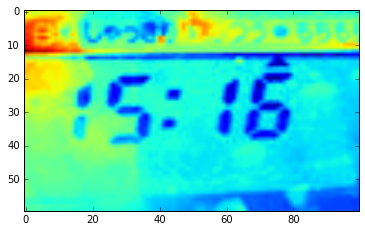

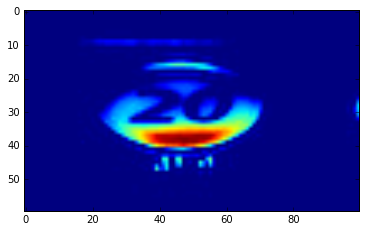

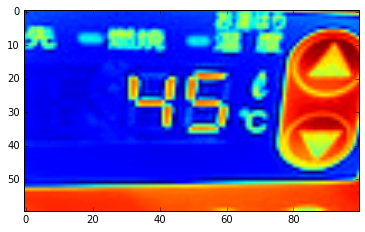

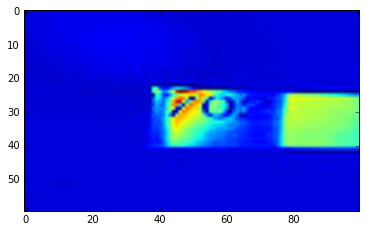

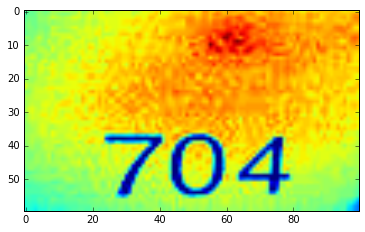

In [6]:
shape =np.array(own_data_box).shape

for i in range(len(own_data_box)):
    image = np.array(own_data_box[i])
    image =image.reshape(shape[1], shape[2])
    plt.imshow(image)
    plt.show()

In [28]:
box_own_labels = np.array([[[0, 0, 0, 0],[14, 22, 6, 23], [25, 20, 17, 23], [58, 22, 6, 23], [66, 20, 16, 23]],  
[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [30, 20 , 17,  20 ], [47, 20 , 17,  20 ]],  
[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [30, 18, 16, 21], [47, 18, 16, 21]],   
[[0, 0, 0, 0], [0, 0, 0, 0], [41, 24, 10, 9], [53, 24, 10, 9], [63, 24, 10, 9]],   
[[0, 0, 0, 0], [0, 0, 0, 0], [22, 35, 19, 21], [41, 35, 19, 21], [61, 35, 19, 21]]]   
).astype(np.float32)

In [7]:
own_data_box = np.array(own_data_box)
shape = own_data_box.shape
own_data_box = own_data_box.reshape(shape[0], shape[1], shape[2], 1)
print (own_data_box.shape)

(5, 60, 100, 1)


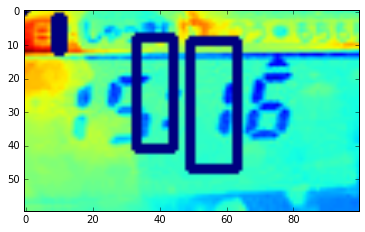

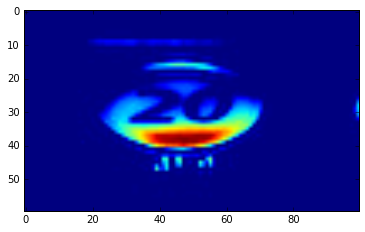

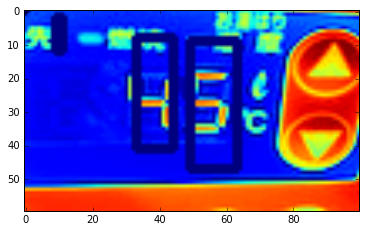

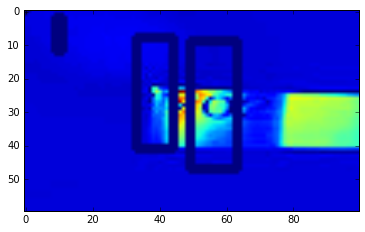

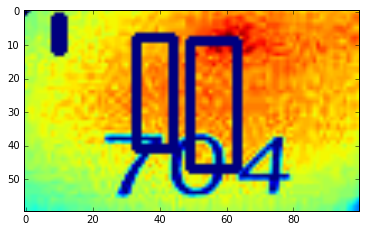

Test box accuracy: 24.2%
Test accuracy: 52.0%


In [32]:
with tf.Session(graph=graph_svhn_box) as session:
    saver.restore(session, "svhn_with_box.ckpt")
    prediction, box_prediction = session.run([own_prediction, own_box_prediction], feed_dict={tf_own_dataset : own_data_box})
    shape =np.array(own_data_box).shape
    for i in range(len(own_data_box)):
        image = np.array(own_data_box[i])
        image =image.reshape(shape[1], shape[2])
        for j in range(5):
            cv2.rectangle(image, (box_prediction[j][i][0], box_prediction[j][i][1]), 
                          ((box_prediction[j][i][0] + box_prediction[j][i][2], 
                            box_prediction[j][i][1]+ box_prediction[j][i][3])), 
                          (0, 255,0), 2)
        plt.imshow(image)
        plt.show()

    
    print('Test box accuracy: %.1f%%' % box_accuracy(box_prediction, box_own_labels))
    print('Test accuracy: %.1f%%' % accuracy(prediction, labels))

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**
The result of 24.2% seems bad at first glance. However, it was surprising to see that the boxes were at least pretty close to the images, especially for image three. It seems that the point of the bounding boxes is to guide the classifier in giving a general area of where the numbers are, not necessarily to perfectly predict the bounding box. In that sense, the model did a decent job in telling the classifier where the numbers are on the image. 
For example, in the first and fourth image, the bounding box and the number of digits is wrong. However, the height and y-locations are almost perfect. The third image is almost perfect, and ideally the model should predict in this way at a high accuracy. 
Also, a test accuracy of 52% is comparable to the test accuracy for Part 3 of 56%. In Part 3, the drop off from the SVHN dataset accuracy to my personal images was significant, suggesting that perhaps the localization+classification method I used here is better suited for more complex images with a lot of noise. In other words, the Part 2 model performed well for SVHN datasets while struggling in more complex images that I took. On the other hand, this model performed similarly for both SVHN images and personal images, which suggests the possibility that the Part 4 model might be better suited for digit recognition, especially if the company or organization has the resources to significantly improve the accuracy. 



----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.




### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.